In [1]:
import os
import pandas as pd
import MeCab
import faiss
import torch
from tqdm import tqdm
from glob import glob
from ast import literal_eval
from langchain_community.document_loaders import DataFrameLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_community.retrievers import BM25Retriever
from langchain.schema import Document
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_huggingface import HuggingFaceEmbeddings

import matplotlib.pyplot as plt

In [2]:
# Mecab
mecab = MeCab.Tagger()
def extract_nouns(text):
    try:
        parsed = mecab.parse(text)
        nouns = []
        for line in parsed.splitlines():
            if '\t' in line:  # MeCab 출력에서 유효한 줄만 처리
                word, feature = line.split('\t')
                if feature.startswith('NNG') or feature.startswith('NNP'):  # 보통명사, 고유명사
                    nouns.append(word)
        return nouns
    except Exception as e:
        print(f"Error during MeCab parsing: {e}")
        return text  # 실패 시 원문 반환

In [3]:
# 성능 평가 함수: Hit@K, MRR@K, Precision, Recall, F1-score
# Hit@K: K개 문서 중 관련 문서가 포함되어 있는지 여부
# MRR@K: K개 문서 중 관련 문서가 높은 순위로 검색되었는지
# Precision: K개 문서 중 실제 관련 문서의 비율

def evaluate_metrics(df, retriever):
    result_df = df.copy()
    
    # retrieval
    result_df['reference'] = ""
    for idx, row in result_df.iterrows():
        retrieved_docs = retriever.invoke(row['query'])
        references = [ref.page_content for ref in retrieved_docs]
        result_df.loc[idx, 'reference'] = str(references)
    
    # metric 계산
    total_hits = 0  # 전체 hit 수
    total_reciprocal_rank = 0.0  # 전체 역순위 합계
    total_precision = 0.0  # 전체 precision
    total_rows = len(df)  # 전체 데이터 수
    result_df[['hit', 'rank', 'precision']] = [False, 0, 0.0]

    for idx, row in result_df.iterrows():
        # 키워드를 쉼표로 분리
        keywords = [kw.strip() for kw in row['keyword'].split(',')]

        # 검색된 문서 리스트
        references = eval(row['reference'])

        K = len(references)  # 검색된 문서 수 (Top K)
        relevant_retrieved_docs = 0  # 검색 결과 중 관련 문서의 수 초기화
        rank = 0  # 관련 문서의 첫번째 등장 순위 초기화
        found = False

        for i, doc in enumerate(references):
            # 문서의 공백 제거
            doc_no_space = doc.replace(' ', '').replace('\n', '')
            doc_is_relevant = False
            for kw in keywords:
                # 키워드의 공백 제거
                kw_no_space = kw.replace(' ', '')
                # 키워드가 문서에 포함되어 있는지 확인
                if kw_no_space in doc_no_space:
                    doc_is_relevant = True
                    if not found:
                        rank = i + 1  # 순위는 1부터 시작
                        found = True
                    break  # 키워드를 찾았으므로 내부 루프 종료
            if doc_is_relevant:
                relevant_retrieved_docs += 1  # 관련된 문서의 수 1 증가

        if rank > 0:
            result_df.loc[idx, 'hit'] = True
            result_df.loc[idx, 'rank'] = rank
            total_hits += 1  # hit 증가
            reciprocal_rank = 1.0 / rank  # 역순위 계산
            total_reciprocal_rank += reciprocal_rank  # 역순위 합계에 추가

        # 현재 쿼리에 대한 precision 계산
        precision = relevant_retrieved_docs / K if K > 0 else 0
        result_df.loc[idx, 'precision'] = precision
        total_precision += precision

    # 전체 metric 계산
    hit_at_k = total_hits / total_rows
    mrr_at_k = total_reciprocal_rank / total_rows
    avg_precision = total_precision / total_rows

    return result_df, hit_at_k, mrr_at_k, avg_precision


In [4]:
# 메트릭 시각화 함수
def plot_metrics(result_df):
    topk = len(eval(result_df.iloc[0].reference))
    # 각 K에 대한 메트릭을 저장할 딕셔너리 초기화
    hit_at_k = {}
    mrr_at_k = {}
    precision_at_k = {}
    total_rows = len(result_df)

    for K in range(1, topk+1):
        total_hits = 0
        total_reciprocal_rank = 0.0
        total_precision = 0.0

        for idx, row in result_df.iterrows():
            keywords = [kw.strip() for kw in row['keyword'].split(',')]
            references = eval(row['reference'])[:K]

            relevant_retrieved_docs = 0
            rank = 0
            found = False

            for i, doc in enumerate(references):
                doc_no_space = doc.replace(' ', '').replace('\n', '')
                doc_is_relevant = False
                for kw in keywords:
                    kw_no_space = kw.replace(' ', '')
                    if kw_no_space in doc_no_space:
                        doc_is_relevant = True
                        if not found:
                            rank = i + 1
                            found = True
                        break
                if doc_is_relevant:
                    relevant_retrieved_docs += 1

            if rank > 0:
                total_hits += 1
                reciprocal_rank = 1.0 / rank
                total_reciprocal_rank += reciprocal_rank

            precision = relevant_retrieved_docs / K if K > 0 else 0
            total_precision += precision

        hit_at_k[K] = total_hits / total_rows
        mrr_at_k[K] = total_reciprocal_rank / total_rows
        precision_at_k[K] = total_precision / total_rows

    # 그래프 그리기
    Ks = list(range(1, topk+1))
    hit_values = [hit_at_k[K] for K in Ks]
    mrr_values = [mrr_at_k[K] for K in Ks]
    precision_values = [precision_at_k[K] for K in Ks]

    plt.figure(figsize=(12, 4))

    # Hit@K 그래프
    plt.subplot(1, 3, 1)
    plt.plot(Ks, hit_values, marker='o')
    plt.title('Hit@K')
    plt.xlabel('K')
    plt.ylabel('Hit@K')
    plt.xticks(Ks)
    plt.grid(True)

    # MRR@K 그래프
    plt.subplot(1, 3, 2)
    plt.plot(Ks, mrr_values, marker='o')
    plt.title('MRR@K')
    plt.xlabel('K')
    plt.ylabel('MRR@K')
    plt.xticks(Ks)
    plt.grid(True)

    # Precision@K 그래프
    plt.subplot(1, 3, 3)
    plt.plot(Ks, precision_values, marker='o')
    plt.title('Precision@K')
    plt.xlabel('K')
    plt.ylabel('Precision@K')
    plt.xticks(Ks)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [5]:
korean_history_term_merged = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/korean_history_term_merged.csv')
korean_history_textbook_25_merged = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/korean_history_textbook_25_merged.csv')
korean_webtext_edu = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/korean-webtext-edu.csv')
korean_wikipedia_edu = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/korean-wikipedia-edu.csv')
openstax_econ = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/openstax_econ.csv')
openstax_poli = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/openstax_poli.csv')
openstax_psych = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/openstax_psych.csv')
openstax_us_hist = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/openstax_us_hist.csv')
openstax_world_hist1 = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/openstax_world_hist1.csv')
openstax_world_hist2 = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/openstax_world_hist2.csv')
train_aug_qa_cleaned = pd.read_csv('/data/ephemeral/home/contest_baseline_code/data/rag/train_aug_qa_cleaned.csv')

print(korean_history_term_merged.shape)
print(korean_history_textbook_25_merged.shape)
print(korean_webtext_edu.shape)
print(korean_wikipedia_edu.shape)
print(openstax_econ.shape)
print(openstax_poli.shape)
print(openstax_psych.shape)
print(openstax_us_hist.shape)
print(openstax_world_hist1.shape)
print(openstax_world_hist2.shape)
print(train_aug_qa_cleaned.shape)

(793, 3)
(276, 3)
(7807, 3)
(1672, 3)
(2303, 3)
(2137, 3)
(2432, 3)
(3225, 3)
(2231, 3)
(2315, 3)
(818, 3)


In [6]:
######################
## RAG Data Loading ##
######################
rag_folder = "/data/ephemeral/home/contest_baseline_code/data/rag"
rag_files = glob(f"{rag_folder}/*.csv")

# Concatenate RAG data
rag_data_source = [pd.read_csv(file) for file in rag_files]
rag_data = pd.concat(rag_data_source, axis=0, ignore_index=True)
print(f"RAG Data Count: {rag_data.shape[0]}")

# Use only documents with at least 25 characters
rag_data = rag_data[rag_data.context.str.len() >= 25]
print(f"filtered (len > 25) RAG Data Count: {rag_data.shape[0]}")

# Retrieval evaluation dataset
eval_set = pd.read_csv("/data/ephemeral/home/contest_baseline_code/data/rag/external_knowledge_w_label_keyword.csv")
prompt = "{paragraph}\n{question}\n{choices}"
eval_set['query'] = ""  # input 형태 맞추기
for idx, row in eval_set.iterrows():
    problems = literal_eval(row['problems'])
    question = problems['question']
    choices = problems['choices']
    choices_str = " ".join(choices)
    query = prompt.format(paragraph=row['paragraph'], question=question, choices=choices_str)
    eval_set.loc[idx, 'query'] = query
eval_set.head()

RAG Data Count: 26621
filtered (len > 25) RAG Data Count: 25548


,id,paragraph,problems,question_plus,label,keyword,query
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",{'question': '상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두...,NaN,한국사,"남인, 기사환국","상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)..."
1,generation-for-nlp-426,"한양이라는 이름은 조선 왕조가 건국되면서 수도로 삼은 지역의 이름으로, 한강의 북쪽...","{'question': '한양에 대한 설명으로 옳지 않은 것은?', 'choices...",NaN,한국사,"남경, 한양","한양이라는 이름은 조선 왕조가 건국되면서 수도로 삼은 지역의 이름으로, 한강의 북쪽..."
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,"{'question': '(가) 지역에 대한 설명으로 옳은 것은?', 'choice...",NaN,한국사,"서경, 동녕부",나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,"{'question': '밑줄 친 ‘그’에 대한 설명으로 옳은 것은?', 'choi...",NaN,한국사,"김유신, 김춘추",이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...","{'question': '(가) 인물이 추진한 정책으로 옳지 않은 것은?', 'ch...",NaN,한국사,"흥선대원군, 비변사","선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가..."


In [7]:
#######################
## Rag Data Chunking ##
#######################
loader = DataFrameLoader(rag_data, page_content_column='context')
documents = loader.load()

# Chunking
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator=". ",
    chunk_size=600,
    chunk_overlap=200,
    encoding_name='cl100k_base'
)
split_docs = text_splitter.split_documents(tqdm(documents))
print(f"Chunked Document Count: {len(split_docs)}")

100%|██████████| 25548/25548 [00:00<00:00, 749794.13it/s]
Created a chunk of size 676, which is longer than the specified 600
Created a chunk of size 642, which is longer than the specified 600
Created a chunk of size 789, which is longer than the specified 600
Created a chunk of size 616, which is longer than the specified 600
Created a chunk of size 1019, which is longer than the specified 600
Created a chunk of size 743, which is longer than the specified 600
Created a chunk of size 793, which is longer than the specified 600
Created a chunk of size 704, which is longer than the specified 600
Created a chunk of size 654, which is longer than the specified 600
Created a chunk of size 670, which is longer than the specified 600
Created a chunk of size 635, which is longer than the specified 600
Created a chunk of size 619, which is longer than the specified 600
Created a chunk of size 1172, which is longer than the specified 600
Created a chunk of size 1113, which is longer than the s

Chunked Document Count: 81077


In [ ]:
###############
## Vector DB ##
###############
model_name = 'dragonkue/BGE-m3-ko'
device = 'cuda'

embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={'device': device},
    encode_kwargs={'normalize_embeddings': True},
)

# Vector DB path
vector_store_path = f"/data/ephemeral/home/workspace/contest_baseline_code/data/db/faiss_{model_name}_count-{len(split_docs)}"

# Load existing vector store or create new one
if os.path.exists(vector_store_path):
    print("Loading existing vector store...")
    vector_store = FAISS.load_local(
        vector_store_path,
        embeddings,
        allow_dangerous_deserialization=True
        )
else:
    print("Creating new vector store...")
    vector_store = FAISS.from_documents(
        [split_docs[0]],
        embedding=embeddings,
        distance_strategy=DistanceStrategy.COSINE
    )

    # # 인덱스를 GPU로 이동
    # res = faiss.StandardGpuResources()
    # gpu_index = faiss.index_cpu_to_gpu(res, 0, vector_store.index)  # 0은 GPU ID
    # vector_store.index = gpu_index    
    
    # 배치 크기 설정
    batch_size = 4  # 적절한 배치 크기로 조절 가능
    docs_to_add = split_docs[1:]
    with tqdm(total=len(docs_to_add), desc="Ingesting documents") as pbar:
        for i in range(0, len(docs_to_add), batch_size):
            batch_docs = docs_to_add[i:i + batch_size]
            vector_store.add_documents(batch_docs)
            pbar.update(len(batch_docs))
            torch.cuda.empty_cache()
            
    # # 인덱스를 다시 CPU로 이동하여 저장
    # cpu_index = faiss.index_gpu_to_cpu(vector_store.index)
    # vector_store.index = cpu_index
    
    # Save vector DB
    vector_store.save_local(vector_store_path)

# Check the number of documents in the vector store
doc_count = vector_store.index.ntotal
print(f"Document Count in Vector Store: {doc_count}")

Creating new vector store...


Ingesting documents:   6%|▋         | 5112/81076 [01:29<21:39, 58.43it/s] 

In [ ]:
#######################
## Define Retrievers ##
#######################

# Set top k for retrievers
topk=10
rerank_topk = 2

# Sparse retriever
bm25_retriever = BM25Retriever.from_documents(
    documents=split_docs,
    k=topk,
    preprocess_func=extract_nouns,  # MeCab 전처리 함수
    # metadata={"source": "faq", "version": "1.0"}, # 추가 메타데이터 정보(원본 데이터 뭔지) 출력 가능
    # vectorizer=, # 커스텀 벡터라이저 사용 가능
)

# Dense retriever
faiss_retriever = vector_store.as_retriever(search_kwargs={"k":topk})

# # Ensemble retriever
# ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5])

# # Reranker
# reranker = HuggingFaceCrossEncoder(
#     model_name="dragonkue/bge-reranker-v2-m3-ko",
#     model_kwargs={'device': 'cuda'}
# )

# # Compressor
# compressor = CrossEncoderReranker(model=reranker, top_n=rerank_topk)
# compression_retriever = ContextualCompressionRetriever(
#     base_compressor=compressor, base_retriever=ensemble_retriever
# )

# Retrieval 성능 확인

## Sparse

In [ ]:
# 결과 계산 및 출력
result_df, hit, mrr, avg_precision = evaluate_metrics(eval_set, bm25_retriever)

print("[Sparse Retrieval]")
print(f"Hit@{topk}: {hit:.4f}")
print(f"MRR@{topk}: {mrr:.4f}")
print(f"Precision@{topk}: {avg_precision:.4f}")

[Sparse Retrieval]
Hit@5: 0.6176
MRR@5: 0.4773
Precision@5: 0.3392


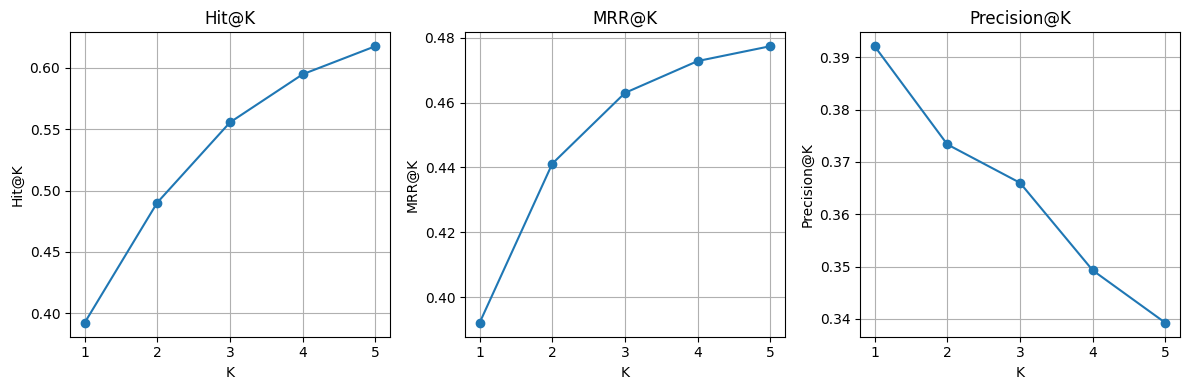

In [ ]:
# topk개 이하에서 metric 변화 시각화
plot_metrics(result_df)

In [ ]:
# 결과 하나씩 조회
idx = 0
row = result_df.iloc[idx]
references = eval(row['reference'])

print(f"[결과]")
print(f"Hit: {row['hit']}")    # 검색된 문서 중, 연관 문서가 존재하는지 여부 (T/F)
print(f"Rank: {row['rank']}")  # 검색된 문서 중, 연관 문서의 순위 (1, ..., TopK)
print(f"Precision: {row['precision']}\n")  # 검색된 문서 중, 연관 문서의 비율
print(f"[키워드]\n{row['keyword']}\n")
print(f"[문제]\n{row['query']}\n")
print("[검색 결과]")
for i, ref in enumerate(references):
    print(f"Result {i+1}: {ref}")

[결과]
Hit: True
Rank: 1
Precision: 0.2

[키워드]
남인, 기사환국

[문제]
상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.
상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?
ㄱ, ㄴ ㄱ, ㄷ ㄴ, ㄹ ㄷ, ㄹ

[검색 결과]
Result 1: 상소하여 아뢰기를, “신이 좌참찬 송준길이 올린 차자를 보았는데, 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다. 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다. …(중략)… 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참최 3년복을 입는 것은 아닙니다.”라고 하였다.－현종실록－ㄱ.기사환국으로 정권을 장악하였다. ㄴ.인조반정을 주도하여 집권세력이 되었다. ㄷ.정조 시기에 탕평정치의 한 축을 이루었다. ㄹ.이이와 성혼의 문인을 중심으로 형성되었다.
Result 2: ㄱ.사병을 혁파하였다. ㄴ.집현전을 폐지하였다. ㄷ.경국대전을 완성하였다. ㄹ.6조 직계제를 시행하였다.
Result 3: ㄱ.중국 문화의 영향을 받아 만들어진 벽돌무덤이다. ㄴ.천장은 각을 줄여 쌓는 평행 고임 구조로 되어 있다. ㄷ.무덤방의 네 벽면에 회가 칠해지고 벽화가 그려져 있다.

## Dense

In [ ]:
# 결과 계산 및 출력
result_df, hit, mrr, avg_precision = evaluate_metrics(eval_set, faiss_retriever)

print("[Dense Retrieval]")
print(f"Hit@{topk}: {hit:.4f}")
print(f"MRR@{topk}: {mrr:.4f}")
print(f"Precision@{topk}: {avg_precision:.4f}")

In [ ]:
# topk개 이하에서 metric 변화 시각화
plot_metrics(result_df)

In [ ]:
# 결과 하나씩 조회
idx = 0
row = result_df.iloc[idx]
references = eval(row['reference'])

print(f"[결과]")
print(f"Hit: {row['hit']}")    # 검색된 문서 중, 연관 문서가 존재하는지 여부 (T/F)
print(f"Rank: {row['rank']}")  # 검색된 문서 중, 연관 문서의 순위 (1, ..., TopK)
print(f"Precision: {row['precision']}\n")  # 검색된 문서 중, 연관 문서의 비율
print(f"[키워드]\n{row['keyword']}\n")
print(f"[문제]\n{row['query']}\n")
print("[검색 결과]")
for i, ref in enumerate(references):
    print(f"Result {i+1}: {ref}")

In [ ]:
# ##############################
# ## Save Retrieval Documents ##
# ##############################
# tqdm.pandas()

# target_data = pd.read_csv("../../contest_baseline_code/data/raw/test.csv")
# prompt = "{paragraph} {question} {choices}"

# def process_row(row):
#     problems = literal_eval(row['problems'])
#     paragraph = row['paragraph']
#     question = problems['question']
#     choices = problems['choices']
#     choices_str = " ".join(choices)
    
#     query = prompt.format(paragraph=paragraph, question=question, choices=choices_str)
    
#     if len(paragraph) > 500: # 보수적 기준: 약 600~700자, 널널한 기준: 약 300~400자
#         return None
#     docs = compression_retriever.invoke(query)
#     retrieved_docs = [doc.page_content for doc in docs]
#     return retrieved_docs
    
# # query 생성
# target_data['reference'] = target_data.progress_apply(process_row, axis=1)

# # 결과 저장
# target_data.to_csv("../../contest_baseline_code/data/preprocessed/test_rag.csv", index=False)


100%|██████████| 869/869 [15:53<00:00,  1.10s/it]
